### Note: Alogorithm is changed from the slide 
Initialize the weight vector $\vec{w}$ with small random numbers and the scalar intercept/bias $b$ with zero.

Then, iterate the following steps until a stopping criterion or max number of epochs is fulfilled.
1. Find the support vector matrix $\vec{X}_{s v}$ and their label vector $\vec{t}_{s v}$ using the following equation.
$$
\vec{t} * (\vec{X} \cdot \vec{w} + b)<1
$$
2. Compute the cost J:
$$
J=\frac{1}{2} \vec{w}^{T} \vec{w}+C\left[\sum\left(1- \vec{t}_{s v} * \vec{X}_{s v} \cdot \vec{w}\right)-b * \sum \vec{t}_{s v}\right]
$$
3. Compute the derivative of the cost function with respect to the weight vector $\vec{w}$ and the intercept/bias $b$ :
$$
\nabla_{\vec{w}} J=\vec{w}-C * \sum (\vec{t}_{s v} * \vec{X}_{s v})
$$

$$
\nabla_{b} J=-C * \sum \vec{t}_{s v}
$$
4. Update both $\vec{w}$ and $b$.
$$
\begin{array}{c}
\vec{w}:=\vec{w}-\eta * \nabla_{\vec{w}} J \\
b:=b-\eta * \nabla_{b} J
\end{array}
$$

In [1]:
import numpy as np 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, classification_report


In [2]:
iris = load_iris()
X = iris["data"][:, (2, 3)]  
y = (iris["target"] == 2).astype(np.int)[:,None]


In [3]:
Z = np.hstack([X,y])
np.random.shuffle(Z)
X= Z[:,0:2]
y = Z[:,2]

In [4]:
# Standarize the data
X = (X - np.mean(X))/np.std(X)

def split_trainTest(X,y,t):
    train_size = int((1-t) * X.shape[0])   
    return X[:train_size],X[train_size:],y[:train_size],y[train_size:]

X_train, X_test, y_train, y_test = split_trainTest(X,y,t=0.2)

In [5]:
class Linear_SVC:
    def __init__(self, C=1, max_iter=100, tol=None, learning_rate='constant',learning_rate_init=0.001, t_0=1, t_1=500, early_stopping=False, validation_fraction=0.1,**kwargs):
        self.C = C
        self.w = np.random.rand(2,1)
        self.b = 0
        #self.w = np.reshape(np.array([[1.60381071, 3.05536121]]),(2,1))
        #self.b = -1.13503736      
        self.epochs = max_iter
        self.lr_sc = learning_rate
        self.learning_rate = learning_rate_init
        self.tol = tol 
        self.t_0 = t_0
        self.t_1 = t_1
        self.loss = 1e5
        self.intercept_ = None
        self.coef_ = None
        self.support_vectors_ = None
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
    
    def fit(self,X,y):
        ##ADd early_stopping like Assignment 3
        epch_counter = 0
        
        val_loss = []
        self.validation_score=1e5
        
        if self.early_stopping:
            X, X_valid, y, y_valid = split_trainTest(X, y, self.validation_fraction)
        
        # y was re-assigned into 1 and -1.
        t = (2 * y - 1)[:,None]
        
        
        while epch_counter < self.epochs:
            loss = self.loss
            epch_counter += 1
            validation_score = self.validation_score
            #print(f'Epoch: {epch_counter}')
            #pdb.set_trace()
            w = self.w
            b = self.b
            if(self.lr_sc == "adaptive"):
                self.learning_rate = self.t_0 /(epch_counter + self.t_1)    
        
            idx_sv = ((t * ((X @ w) + b)) < 1).ravel()
            X_sv = X[idx_sv]
            t_sv = t[idx_sv]
            
            self.loss = ((0.5 * (w.T @ w))+ (self.C*(np.sum(1- (t_sv * (X_sv @ w))) - b* np.sum(t_sv)))).item()
            #self.loss = ((0.5 * (w.T @ w))+ (self.C*(np.sum(1- X_sv@w) - b* np.sum(t_sv)))).item()
            #self.loss = ((0.5 * (w.T @ w))+ (self.C*np.sum((np.maximum(0,1-t*(X@w+b)))))).item()
            # print(self.loss)
            dw = w - (self.C * np.sum(t_sv * X_sv))
            db = -self.C * np.sum(t_sv)
            
            self.w = w - self.learning_rate * dw
            self.b = b - self.learning_rate * db
            self.support_vectors_ = X_sv
            ## Assing intercept,Coef and Support vec
            
            if self.early_stopping:
                t_val = (2 * y_valid - 1)[:,None]
                self.validation_score = ((0.5 * (self.w.T @ self.w))+ (self.C * (np.sum(1- (X_valid @ self.w)) - b * np.sum(t_val)))).item()
                val_loss.append(self.validation_score)
                # print("self.validation_score", self.validation_score)
                # print("self.loss", self.loss)
                if (self.validation_score > validation_score):
                    print(f'\nEarly Stopping at : {epch_counter}\n')
                    plt.plot(range(epch_counter), val_loss, "--", color='darkorange', lw = 2)
                    plt.xlabel("epoch")
                    plt.ylabel("Loss : J(w)")
                    break
            
            if (self.tol != None) and (np.abs(self.loss - loss) < self.tol):         
                break
                    
        self.coef_ = np.array([w])
        self.intercept_ = np.array([b])
        
    def predict(self,X):
        return ((X@self.coef_[0] + self.intercept_[0]) >= 1).astype(np.int)
        
        

In [6]:
def sFold(folds,data,labels,model,error_fuction,**model_args):
    if(labels.shape == (labels.shape[0],)):
        labels = np.expand_dims(labels,axis=1)
    dataset = np.concatenate([data,labels],axis=1)
    s_part = s_partition(dataset,folds)
    pred_y = []
    true_y = []
    err_func = []
    for idx,val in enumerate(s_part):
        test_y = val[:,-1]
        #test_y = np.expand_dims(test_y, axis=1)
        test = val[:,:-1]
        train = np.concatenate(np.delete(s_part,idx,0))
        label = train[:,-1]
        train = train[:,:-1]        
        #model.fit(train,label,**model_args) 
        model.fit(train,label)  
        pred = model.predict(test)
        
        pred_y.append(pred)
        true_y.append(test_y[:,None])
        err_func.append(error_fuction(pred,test_y[:,None]))
    avg_error = np.array(err_func).mean()
    result = {'Expected labels':true_y, 'Predicted labels': pred_y,'Average error':avg_error }
    return result

def s_partition(x,s):
    return np.array_split(x,s)

In [7]:
def accuracy(x,y):
    x,y = np.array(x),np.array(y)
    pred = (x == y).astype(np.int)
    return pred.mean()

In [8]:
def findOptimalSoft():
    validation_accuracy = np.empty((4,6,2,5,5))
    learning_rate_init = [0.1 , 0.01, 0.001, 0.0001]
    C = [0.01,0.5 , 1 , 10, 50, 100]
    learning_rate= ['constant', 'adaptive']
    max_iter = [10, 35, 50, 100, 500]
    tol = [None, 0.1, 1, 0.01, 5]
    maxScore = 0
    for i,lri in enumerate(learning_rate_init):
        for j,c in enumerate(C):
            for k,lr in enumerate(learning_rate):
                for l,mi in enumerate(max_iter):
                    for m,tl in enumerate(tol):
                        model_args = {'learning_rate' : lr,'C':c,'learning_rate_init' : lri,'max_iter' : mi,'tol' : tl}
                        lrSvM = Linear_SVC(**model_args) 
                        result = sFold(5,X,y,lrSvM, error_fuction = accuracy,**model_args)
                        validation_accuracy[i,j,k,l,m] = result['Average error']
                        if validation_accuracy[i,j,k,l,m] > maxScore:
                            maxScore = validation_accuracy[i,j,k,l,m]
                            index = [i,j,k,l,m]

    print(index)
    a,b,c,d,e= index
    print('optimal learning_rate_init: ',learning_rate_init[a])
    print('optimal C: ',C[b])
    print('optimal learning_rate: ',learning_rate[c])
    print('optimal max_iter',max_iter[d])
    print('optimal tol',tol[e])
    print('optimal value',validation_accuracy[a,b,c,d,e])
    opt_dic = {'learning_rate' : learning_rate[c],'C':C[b],'learning_rate_init' : learning_rate_init[a],'max_iter' : max_iter[d],'tol' : tol[e]}   
    return opt_dic

In [9]:
opt_mod = findOptimalSoft()

[0, 1, 0, 0, 3]
optimal learning_rate_init:  0.1
optimal C:  0.5
optimal learning_rate:  constant
optimal max_iter 10
optimal tol 0.01
optimal value 0.9733333333333334


In [10]:
model = Linear_SVC(**opt_mod)

In [11]:
opt_mod

{'learning_rate': 'constant',
 'C': 0.5,
 'learning_rate_init': 0.1,
 'max_iter': 10,
 'tol': 0.01}

In [12]:
model.fit(X_train,y_train)

In [13]:
def decision_boundary_support_vectors(svm_clf, X):
    
    xmin, xmax = X.min() - 1, X.max() + 1
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    

    # At the decision boundary, w1*x1 + w2*x2 + b = 0
    # => x2 = -(b + w1* x1)/w1
    x1 = np.linspace(xmin, xmax, 100)    
    decision_boundary = -(b + w[0]*x1)/w[1]
    shifting_factor_for_margin = 1/w[1]
    upper_margin = decision_boundary + shifting_factor_for_margin
    lower_margin = decision_boundary - shifting_factor_for_margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=200, facecolors='g', label="Support Vectors")
    plt.plot(x1, decision_boundary, "k-", linewidth=2)
    plt.plot(x1, upper_margin, "k--", linewidth=2)
    plt.plot(x1, lower_margin, "k--", linewidth=2)

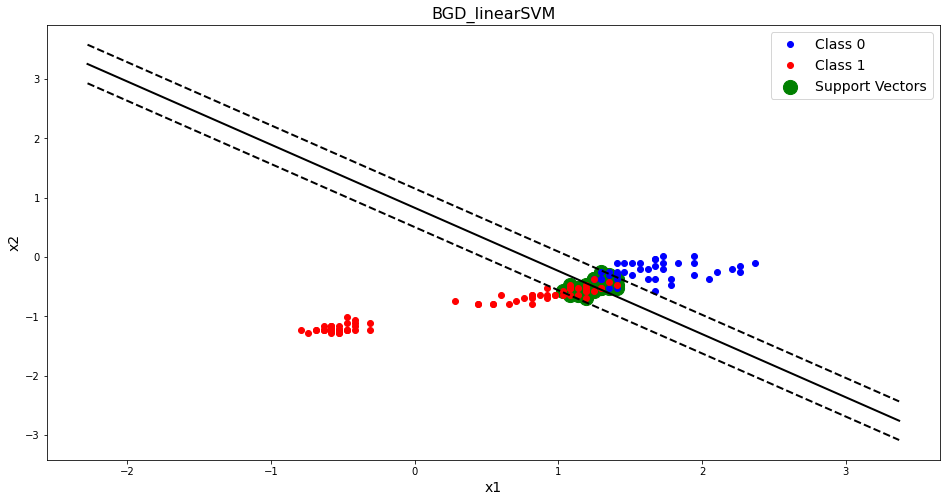

In [14]:
plt.figure(figsize=(16,8))
plt.plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bo", label="Class 0")
plt.plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "ro", label="Class 1")

decision_boundary_support_vectors(model, X_train)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("BGD_linearSVM", fontsize=16)
plt.show()

In [15]:
pred = model.predict(X_train)
print("Train Accuracy: ", accuracy_score(pred, y_train))


y_test_predicted = model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test_predicted, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


Train Accuracy:  0.925
Test Accuracy:  0.9666666666666667

Test Confusion Matrix:
[[21  0]
 [ 1  8]]


In [16]:
# early_stopping


Early Stopping at : 4



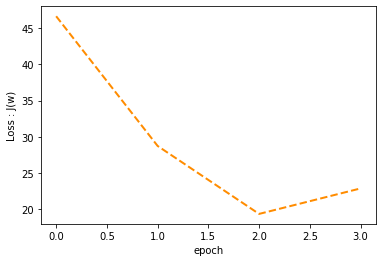

In [17]:
X, y = X_train,y_train
model_early = Linear_SVC(**opt_mod, early_stopping = True, validation_fraction=0.2)
model_early.fit(X,y)

In [18]:
print(model_early.coef_,model_early.intercept_)
support_vectors = model_early.support_vectors_
support_vectors

[[[2.84614088]
  [3.20627284]]] [-3.05]


array([[ 1.51391428, -0.0958717 ],
       [ 1.35293568, -0.52514796],
       [ 1.51391428, -0.31050983],
       [ 1.40659522, -0.47148843],
       [ 1.56757381, -0.20319076],
       [ 1.40659522, -0.2568503 ],
       [ 1.40659522, -0.36416936],
       [ 1.40659522, -0.31050983],
       [ 1.78221194, -0.47148843],
       [ 1.46025475, -0.2568503 ],
       [ 1.46025475, -0.0958717 ],
       [ 1.67489288, -0.36416936],
       [ 1.35293568, -0.2568503 ],
       [ 1.62123335, -0.36416936],
       [ 1.24561662, -0.36416936],
       [ 1.29927615, -0.36416936],
       [ 1.24561662, -0.36416936],
       [ 1.62123335, -0.20319076],
       [ 1.35293568, -0.41782889],
       [ 1.35293568, -0.31050983],
       [ 1.78221194, -0.36416936]])

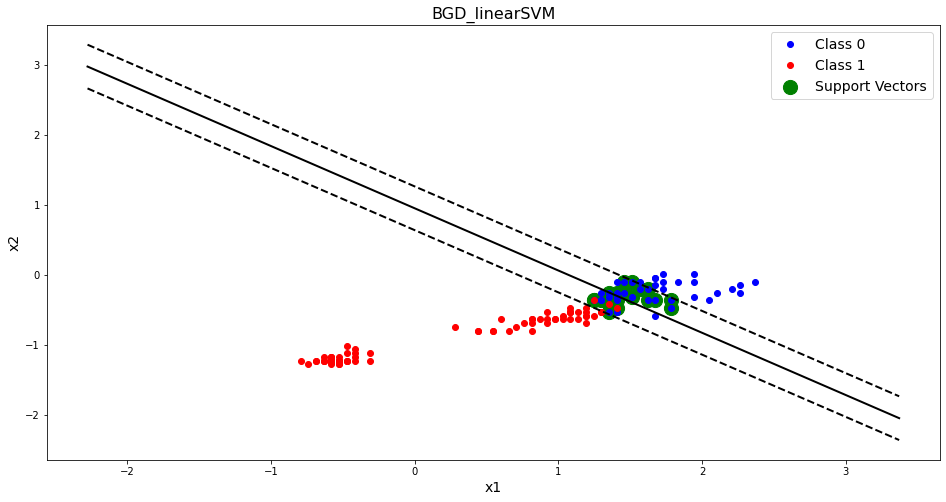

In [19]:
plt.figure(figsize=(16,8))
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bo", label="Class 0")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro", label="Class 1")

decision_boundary_support_vectors(model_early, X)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("BGD_linearSVM", fontsize=16)
plt.show()

In [20]:
pred = model_early.predict(X)
print("Train Accuracy: ", accuracy_score(pred, y))


y_test_predicted = model_early.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test_predicted, y_test))


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

Train Accuracy:  0.8
Test Accuracy:  0.8666666666666667

Test Confusion Matrix:
[[21  0]
 [ 4  5]]
